In [ ]:
!pip install tensorflow==2.8
!pip install keras==2.8

### Load

In [2]:
import os
import numpy as np
from music21 import converter, pitch, interval, instrument, note, stream
from matplotlib import pyplot as plt

from xen.visualise import plotPart, plotSparseNoteSequence
from xen.data.songdata import SongDataSet

data_dir = "../../../ml_training/music/mutopia_guitar/"

dataset = SongDataSet()
dataset.loadMidiDir(data_dir)

print(f'Loaded {len(dataset.songs)} Songs') 


Loading 385 files
Loaded 385 Songs


### Filter

In [3]:
dataset.filterTimeSig('4/4')
print(f'{len(dataset.songs)} Songs') 

95 Songs


###  Encode

In [4]:
from xen.data.codecs import SparseNoteSequenceCodec, FlatNoteSequenceCodec

ticksPerQuarter = 4   # 4 = 16th notes, to allow triplets would need to be 12 = 48 per measure
measuresPerSequence = 1

codec = FlatNoteSequenceCodec(ticksPerQuarter, measuresPerSequence, '4/4')
codec.initEncode(dataset)

print(dataset.sequences.shape)

Ignored 20 sequences from ../../../ml_training/music/mutopia_guitar/Matiegka3.mid
Ignored 2 sequences from ../../../ml_training/music/mutopia_guitar/capricho-arabe.mid
Ignored 24 sequences from ../../../ml_training/music/mutopia_guitar/carcassi-op60-03.mid
Ignored 3 sequences from ../../../ml_training/music/mutopia_guitar/horetzky29.mid
Ignored 84 sequences from ../../../ml_training/music/mutopia_guitar/sorf-op6n11.mid
Ignored 42 sequences from ../../../ml_training/music/mutopia_guitar/sorf-op6n07.mid
Ignored 69 sequences from ../../../ml_training/music/mutopia_guitar/claro-de-luna.mid
Ignored 70 sequences from ../../../ml_training/music/mutopia_guitar/moonlight-guitar-duo.mid
Ignored 1 sequences from ../../../ml_training/music/mutopia_guitar/bwv-1006a_3g.mid
Ignored 1 sequences from ../../../ml_training/music/mutopia_guitar/guitar-skole-no-09.mid
Ignored 2 sequences from ../../../ml_training/music/mutopia_guitar/Sor_Etude_Opus35_14.mid
Ignored 1 sequences from ../../../ml_training/mus

In [14]:
import tensorflow as tf
from xen.models.autoencoder import AutoEncoder

autoencoder = AutoEncoder(dataset.sequences.shape[1], 40)
autoencoder.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

### Train

In [33]:


autoencoder.train(dataset.sequences, epochs = 300)


Epoch 1/300
99/99 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 3/300
99/99 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 4/300
99/99 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 5/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 6/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 7/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 8/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 9/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 10/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 11/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 12/300
99/99 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 13/300
99/99 [=================

In [34]:


def countMatches(indata, outdata):
    matches = 0
    for i in range(0, len(indata)):
        insequence = indata[i]
        outsequence = outdata[i]
        match = True
        for j in range(len(insequence)):
            if ((insequence[j] >= 0.5 and outsequence[j] < 0.5) or (insequence[j] < 0.5 and outsequence[j] >= 0.5)):
                match = False
                # print(i)
        if (match):
            matches = matches + 1
    return matches
    

output = autoencoder.predict(dataset.sequences)

matches = countMatches(dataset.sequences, output)
print(f'{matches/len(dataset.sequences)*100}% recall')



77.39791073124407% recall


### Visualise Latent Space

[[ 1.          0.50179225 -0.1323309  ...  0.9464793  -1.
   0.36632442]
 [ 0.999984    0.97805977  0.6254365  ...  0.72142446 -0.99999934
   0.94428825]
 [ 0.9999974   0.749857    0.5533081  ... -0.9904382  -1.
   0.9707226 ]
 ...
 [ 0.9998114   0.9968204  -0.5323695  ... -0.5866977  -1.
   0.9959267 ]
 [ 0.9999164   0.99674785 -0.89522666 ... -0.73387986 -1.
   0.99999815]
 [ 0.9999997   0.37335244 -0.9494133  ...  0.34932438 -0.99999446
   0.99515855]]


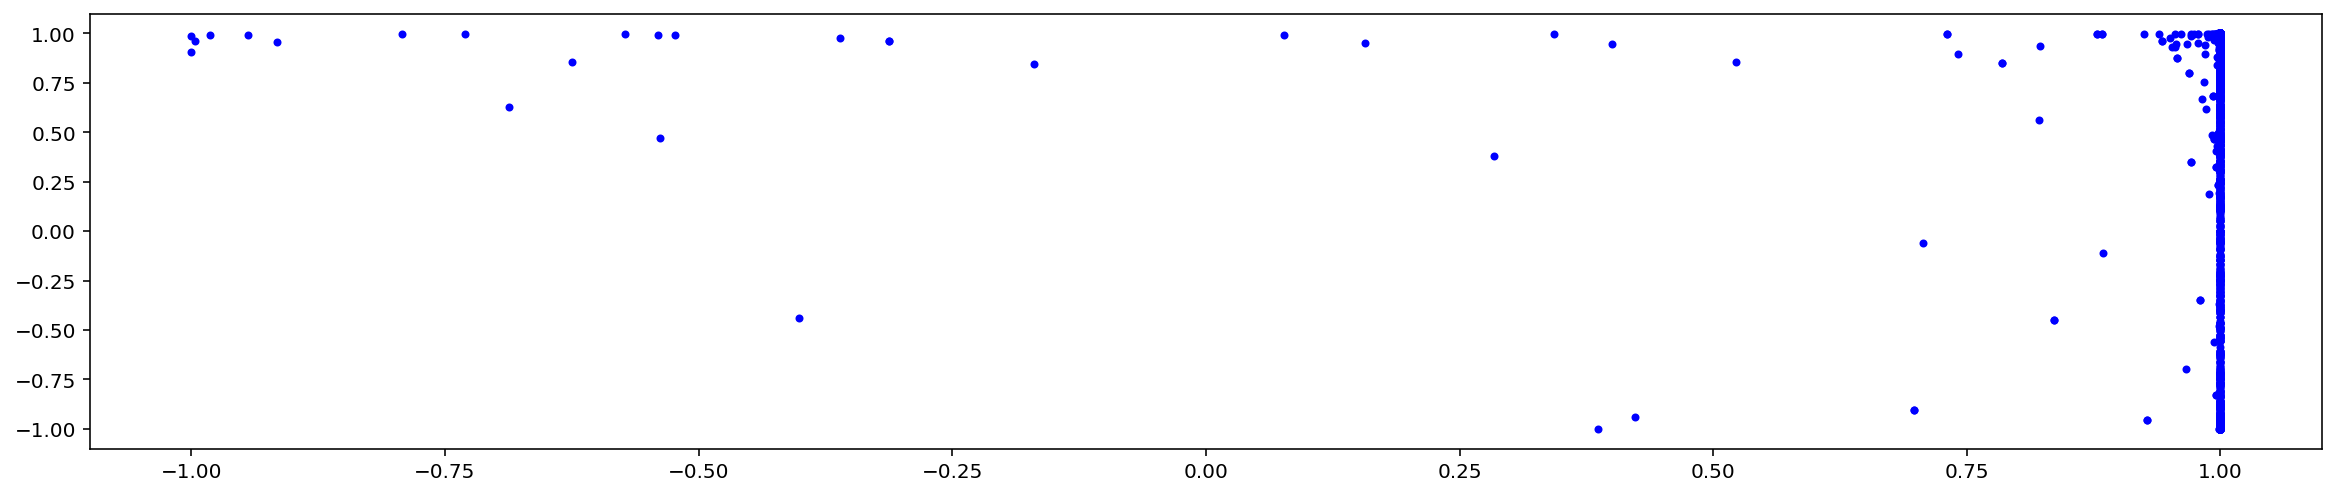

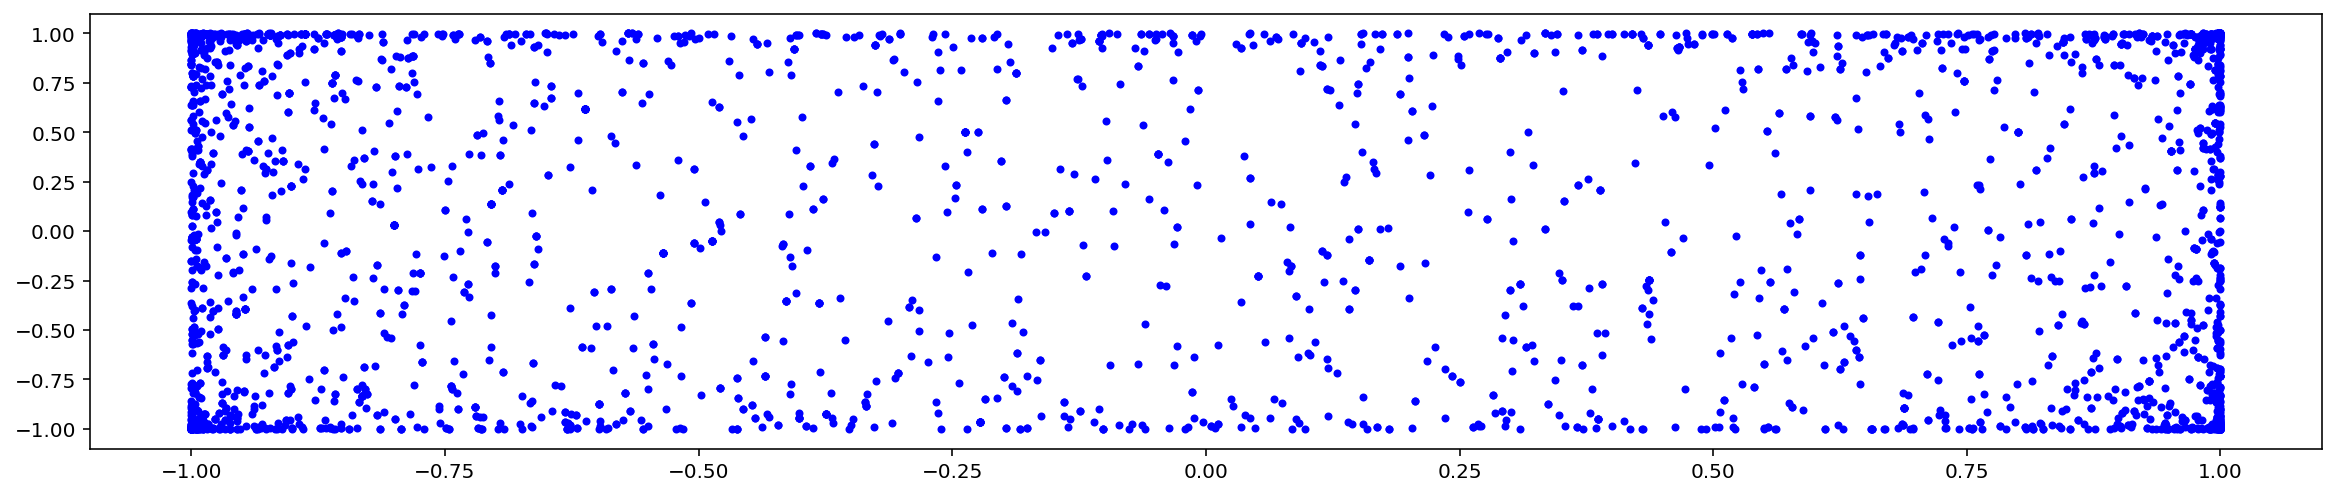

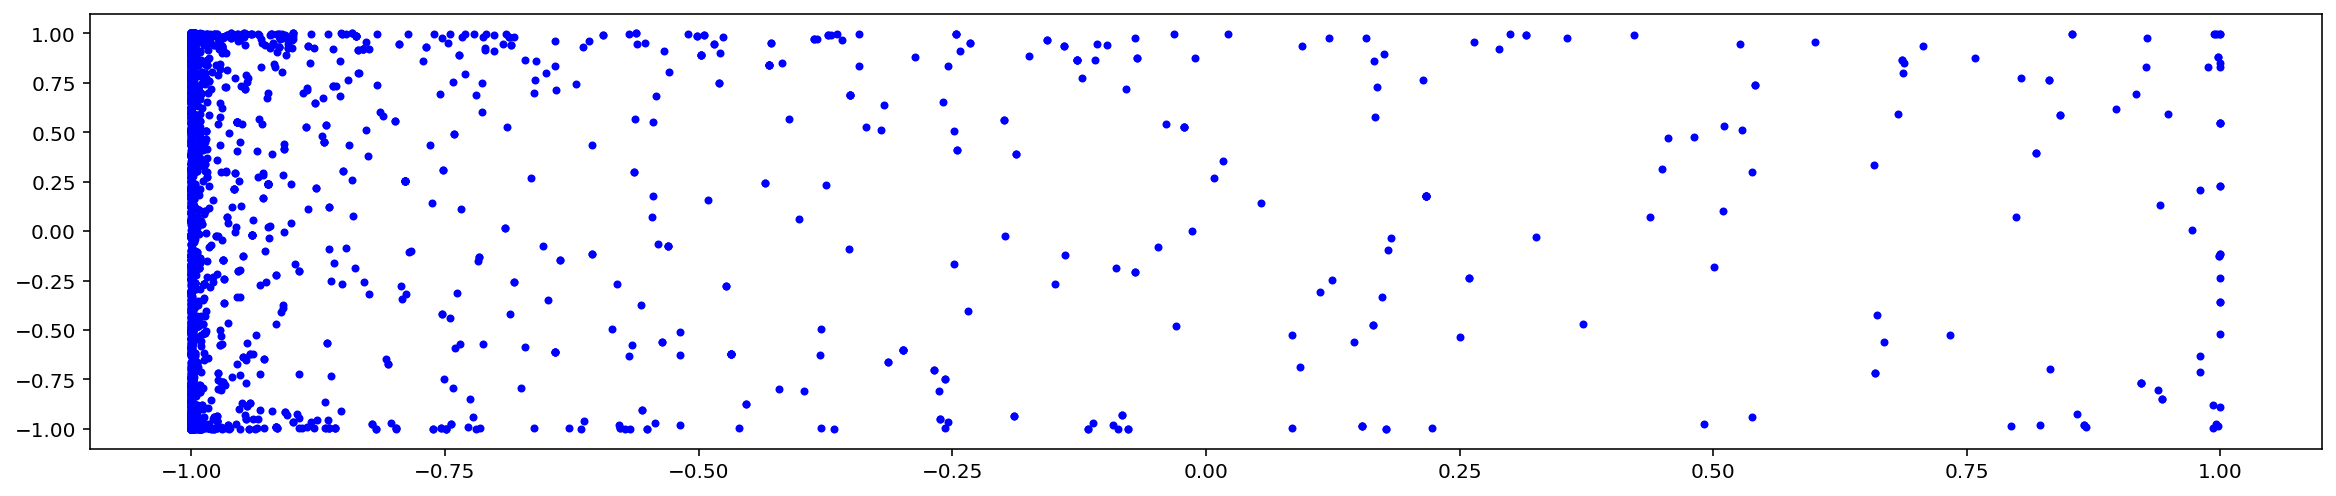

In [37]:
latentdata = autoencoder.encode(dataset.sequences)
print(latentdata)

plt.figure(figsize=(20, 4))
plt.scatter(latentdata[:,0], latentdata[:,1], color='b', marker='.')
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(latentdata[:,2], latentdata[:,3], color='b', marker='.')
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(latentdata[:,4], latentdata[:,5], color='b', marker='.')
plt.show()

In [ ]:
index = 13

print(output.shape)


plotSparseNoteSequence(codec.decode(dataset.sequences[index:index+1])[0])
plotSparseNoteSequence(codec.decode(output[index:index+1])[0], threshold = 0.5)


print(np.amax(output, axis = 1))